In [1]:
"""
Brian Sharber
CSCI 4350/5350
Dr. Joshua Phillips
Honors Contract: Fall 2019
Program Description: Uses toy data sets to illustrate the effectiveness of Hybrid Clustering methods,
which utilize Spectral and Subspace clustering methods. Adjusting the values of gamma and sigma from 
subspace and spectral clustering methods will affect performance. 
Tweak gamma and sigma to get better results in "Find_Sigma_Gamma.ipynb".
"""

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
import math
from cvxpy import *
import numpy as np
import scipy.spatial.distance as sdist
from sklearn.cluster import KMeans
from math import *

In [2]:
# Ground truth
f = open("ground.in", "w+")
for x in range(100):
    f.write(' {:0d}\n'.format(0))

for x in range(100):
    f.write(' {:0d}\n'.format(1))

f.close()
# Convert the floating text in the file to integers when they come in
Xassign = np.loadtxt("ground.in").astype(np.int32)
#print(ground)

In [3]:
# Make some toy data sets
# Set 1: 2 horizontal lines: 0 < y < 1
count = 0.1
f = open("lines-1.in", "w")
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(0))
    count += 0.1
    
count = 0.1
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(1))
    count += 0.1

f.close()
X = np.loadtxt("lines-1.in")

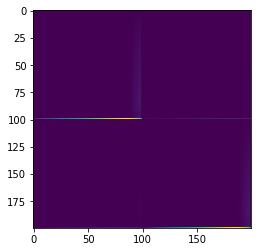

In [4]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    # Can change to cvxpy.Parameter
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.193
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = .45

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[20.35930602 18.1492493   0.71358595]


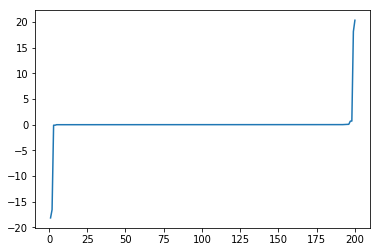

In [5]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.9999999999998976


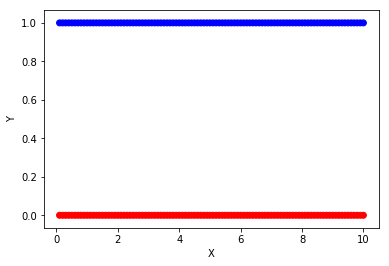

In [6]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [7]:
# Make some toy data sets
# Set 2: 2 horizontal lines 0 < y < 4
count = 0.1
f = open("lines-2.in", "w")
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(0))
    count += 0.1
    
count = 0.1
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(4))
    count += 0.1

f.close()
X = np.loadtxt("lines-2.in")

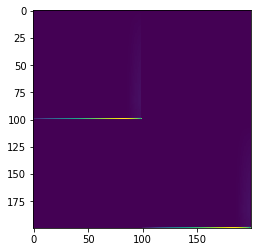

In [8]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.193
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = .6

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[27.17438179 26.51279879  0.87708247]


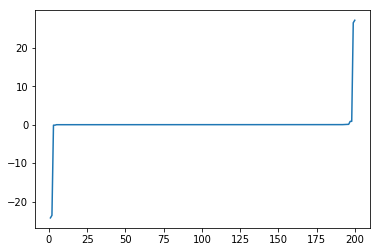

In [9]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.9999999999998976


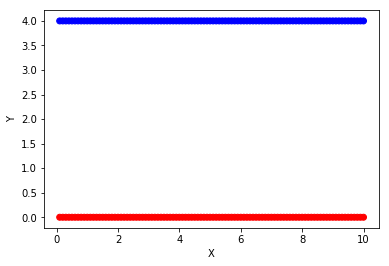

In [10]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [11]:
# Make some toy data sets
# Set 3: horizontal lines: Illustrates K-means performs as expected 
# with enough space given between the 2 lines: 0 < y < 5
count = 0.1
f = open("lines-3.in", "w")
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(0))
    count += 0.1
    
count = 0.1
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:0d}\n'.format(5))
    count += 0.1

f.close()
X = np.loadtxt("lines-3.in")

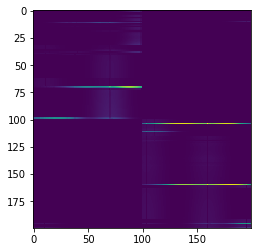

In [12]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.053
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = 1.0

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[9.41023771e-05 8.52326947e-05 4.58876983e-05]


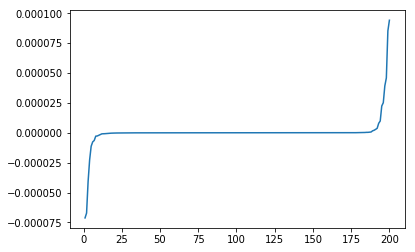

In [13]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.9999999999998976


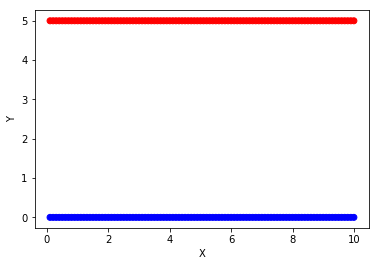

In [14]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [15]:
# Make some toy data sets
# Set 4: Interlocking Circles
# Make one circle

pi = math.pi

def PointsInCircum(r,n):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

f = open("circle-1.in", "w")

circle1 = PointsInCircum(2, 100)

for x in range(100):
    f.write('{:0f} '.format(circle1[x][0]))
    f.write(' {:0f}\n'.format(circle1[x][1]))
    
f.close()
circle1 = np.loadtxt("circle-1.in")
#print(circle1)

# Make one circle shifted to the right.

def PointsInCircum_shift_right(r,n):
    return [(math.cos(2*pi/n*x)*r + 2,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

f = open("circle-2.in", "w")

circle2 = PointsInCircum_shift_right(2, 100)

for x in range(100):
    f.write('{:0f} '.format(circle2[x][0]))
    f.write(' {:0f}\n'.format(circle2[x][1]))
    
f.close()
circle2 = np.loadtxt("circle-2.in")

# Bring the two circles together

f = open("interlocking_circles.in", "w")

for x in range(100):
    f.write('{:0f} '.format(circle1[x][0]))
    f.write(' {:0f}\n'.format(circle1[x][1]))
    
for x in range(100):
    f.write('{:0f} '.format(circle2[x][0]))
    f.write(' {:0f}\n'.format(circle2[x][1]))
    
f.close()
X = np.loadtxt("interlocking_circles.in")

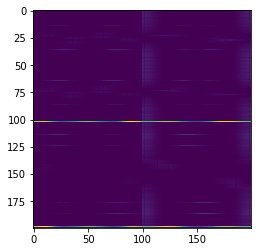

In [16]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.083
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = .8

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[1.50573295e-04 5.51053315e-05 9.39398625e-06]


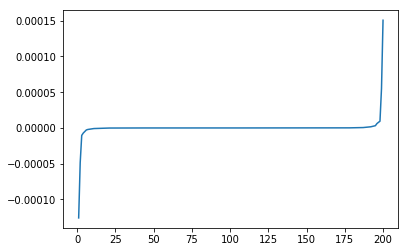

In [17]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.9595312960976473


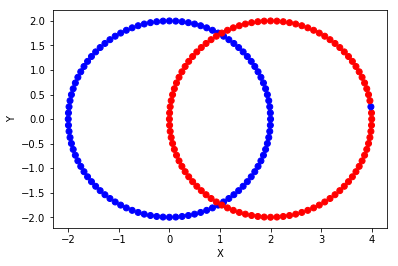

In [18]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [19]:
# Make some toy data sets
# Set 5: Interlocking U's 
# top half

def PointsInCircum_shift_up(r,n):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r + 3) for x in range(0,n+1)]

f = open("u-1.in", "w")

u1 = PointsInCircum_shift_up(2, 200)

for x in range(100):
    f.write('{:0f} '.format(u1[x+100][0]))
    f.write(' {:0f}\n'.format(u1[x+100][1]))
    
f.close()
u1 = np.loadtxt("u-1.in")

# Make some toy data sets
# Interlocking U's: bottom half

def PointsInCircum(r,n):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

f = open("u-2.in", "w")

u2 = PointsInCircum(2, 200)

for x in range(100):
    f.write('{:0f} '.format(u2[x][0]))
    f.write(' {:0f}\n'.format(u2[x][1]))
    
f.close()
u2 = np.loadtxt("u-2.in")

# Interlocking U's: Combine the upper and lower half.

f = open("interlocking_us.in", "w")

for x in range(100):
    f.write('{:0f} '.format(u1[x][0]))
    f.write(' {:0f}\n'.format(u1[x][1]))
    
for x in range(100):
    f.write('{:0f} '.format(u2[x][0]))
    f.write(' {:0f}\n'.format(u2[x][1]))
    
f.close()
X = np.loadtxt("interlocking_us.in")

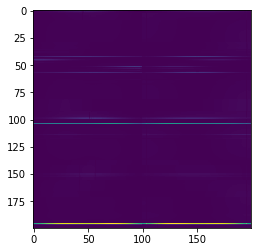

In [20]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.193
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = 1.25

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[5.04394283e-04 1.13850319e-04 2.18114373e-05]


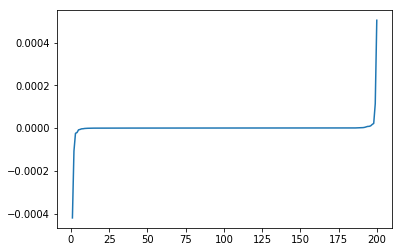

In [21]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.7942888437190337


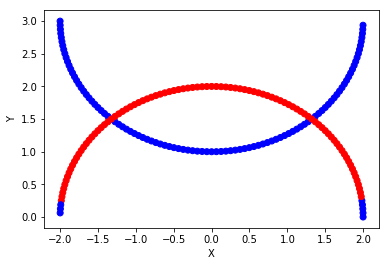

In [22]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [23]:
# Make some toy data sets
# Set 6: 2 lines making an X
count = -50
f = open("x-1.in", "w")
for x in range(100):
    f.write('{:2.2f}'.format(count))
    f.write(' {:2.2f}\n'.format(count))
    count += 1
    
count = -50
y = 0
for x in range(100):
    y = (-1)*(count)
    f.write('{:2.2f}'.format(count))
    f.write(' {:2.2f}\n'.format(y))
    count += 1

f.close()
X = np.loadtxt("x-1.in")

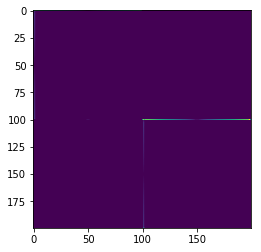

In [24]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.193
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = 1.25

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[1.51387432 1.48814684 1.05389786]


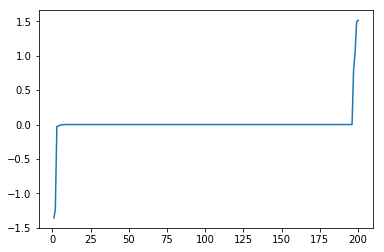

In [25]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.8776994414539376


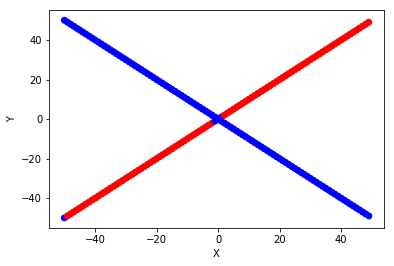

In [26]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [27]:
# Make some toy data sets
# Set 7: Circle within a circle
# Make a circle

def PointsInCircum_subset(r,n):
    return [((math.cos(2*pi/n*x)*r), math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

f = open("circle-3.in", "w")

circle3 = PointsInCircum_subset(6, 100)

for x in range(100):
    f.write('{:0f} '.format(circle3[x][0]))
    f.write(' {:0f}\n'.format(circle3[x][1]))
    
f.close()
circle3 = np.loadtxt("circle-3.in")

# Circle within a circle

f = open("subset_circles.in", "w")

for x in range(100):
    f.write('{:0f} '.format(circle1[x][0]))
    f.write(' {:0f}\n'.format(circle1[x][1]))
    
for x in range(100):
    f.write('{:0f} '.format(circle3[x][0]))
    f.write(' {:0f}\n'.format(circle3[x][1]))
    
f.close()
X = np.loadtxt("subset_circles.in")

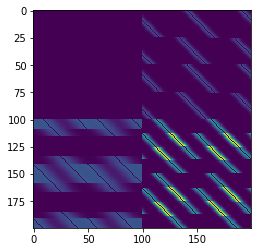

In [28]:
# Subspace Clustering
## Solve for each point as a linear system
## with respect to all other points using
## convex optimization routines
## Basically, we express each point as a
## linear combination of the other points...

## Here we try to minimize the dot-product between
## the coefficients. Sparsity is only needed in
## dot-product space in-so-far as possible.

A = np.transpose(X)
Coeff = np.zeros([np.shape(A)[1],np.shape(A)[1]])
for i in range(np.shape(A)[1]):
    b = A[:,i]
    # gamma must be positive due to DCP rules.
    gamma = Parameter(nonneg="true")
    constraints = None
    
    # Construct the problem.
    x = Variable(np.shape(A)[1])

    ## Lasso
    obj = Minimize(gamma*norm(A*x-b,2) + norm(x, 1))
    constraints = [x[i] == 0]
    ## constraints = [x[i] == 0, sum(x) == 1]

    ## L1-Perfect
    ## obj = Minimize(norm(x, 1))
    ## constraints = [A*x == b, x[i] == 0, sum(x) == 1]
    ## L1-Noisy
    ## obj = Minimize(norm(x, 1))
    ## constraints = [ A*x - b <= gamma, x[i] == 0, sum(x) == 1 ]

    if [constraints == None]:
        prob = Problem(obj)
    else:
        prob = Problem(obj,constraints)

    ## From the original code
    gamma.value = 0.077
    prob.solve(solver='ECOS')
    
    Coeff[:,i] = np.transpose(x.value)
#print(Coeff.shape)

## Refine results...
## Only use magnitude of the coefficients (no negative values)
Coeff = np.abs(Coeff)
## Normalize each row - not needed but doesn't hurt on most examples
## Coeff = Coeff / numpy.apply_along_axis(numpy.max,1,Coeff)[:,None]
## Symmetrize
Coeff = Coeff + np.transpose(Coeff)

## Dimensions in each subspace
d1 = 1
d2 = 1

## What is K?
K = np.max([d1,d2])+1
#print(K)

## Select the top K coefficients
newCoeff = np.zeros(np.shape(Coeff))
indices = np.apply_along_axis(lambda x: np.argsort(x)[::-1],1,Coeff)[:,range(K)]
for x in range(np.shape(Coeff)[0]):
    newCoeff[x,indices[x,:]] = Coeff[x,indices[x,:]]

## Normalize each row - again, not really needed
## newCoeff = newCoeff / numpy.apply_along_axis(numpy.max,1,newCoeff)[:,None]
## Symmetrize
newCoeff = newCoeff + np.transpose(newCoeff)

## Standard...
Xaff = newCoeff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

#Xnorm1 = Xnorm
Xaff1 = Xaff
#print(Xaff_D)

## Spectral Clustering
## Let's implement a simple spectral clustering of the data

## Set affinity scaling factor
sigma = .97

# Number of points in each subspace
N1 = 100
N2 = 100

## Calculate pairwise distances (Euclidean)
Xdist = sdist.squareform(sdist.pdist(X))

## Calculate affinities
Xaff = np.exp((-1.0*np.power(Xdist,2))/(2.0 * np.power(sigma,2)))
Xaff[range(N1+N2),range(N1+N2)] = 0.0
origXaff = Xaff

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Decomposition
#Evals, Evecs = np.linalg.eigh(Xnorm)

#Xnorm2 = Xnorm
Xaff2 = Xaff

#print(Xaff_D)
#print(Xaff_D.shape)

# Apply Hybrid method, combining the 2 matrices with matrix multiplication
#Xnorm = np.matmul(Xnorm1, Xnorm2)
Xaff = np.matmul(Xaff1, Xaff2)

## Get row sums
Xaff_D = np.diagflat(1.0 / np.sqrt(np.apply_along_axis(np.sum,0,Xaff)))

## Normalization
#Xaff_D = pow(Xaff_D, 1/2)
Xnorm = np.matmul(np.matmul(Xaff_D**.5,Xaff),Xaff_D**.5)
#Xnorm = np.matmul(np.matmul(Xaff_D,Xaff),Xaff_D)

## Might not want to show this if the data sizes (N1,N2) are large
plt.imshow(Xnorm)

## Decomposition
Evals, Evecs = np.linalg.eigh(Xnorm)

[3.60616576e-05 1.59358346e-05 1.11082041e-05]


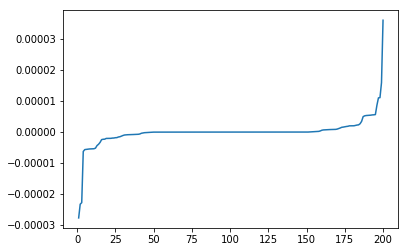

In [29]:
## Next Check the eigenvalues
print(Evals[[-1,-2, -3]])
plt.plot(np.linspace(1,len(Evals),num=len(Evals)),Evals)

Mutual Information
0.4330398630966942


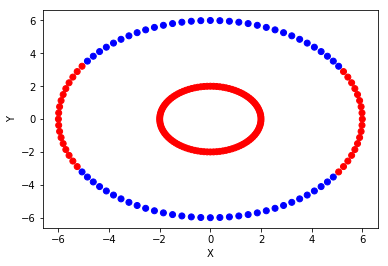

In [30]:
## Perform clustering
Xnew = Evecs[:,[-1,-2]]
kmeans = KMeans(n_clusters=2).fit(Xnew)

## If you want to see the eigen vectors...
## Xone = Evecs[kmeans.labels_==0,:]
## Xtwo = Evecs[kmeans.labels_==1,:]
## plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## If you want it on the PCA projection...
#Xone = Xsvd[0][kmeans.labels_==0,:]
#Xtwo = Xsvd[0][kmeans.labels_==1,:]
#plt.plot(Xone[:,0],Xone[:,1],'bo',Xtwo[:,0],Xtwo[:,1],'ro')

## Let's quantify the performance
jointPDF = np.zeros([2,2])
for x in range(len(Xassign)):
    jointPDF[Xassign[x],kmeans.labels_[x]] += 1
jointPDF /= len(Xassign)
jointPDF += 0.000000000000001
marginals = np.outer(np.apply_along_axis(np.sum,1,jointPDF),np.apply_along_axis(np.sum,0,jointPDF))
print('Mutual Information')
print(np.sum(jointPDF*np.log2(jointPDF/marginals)))

# Plot the Subspace clustering attempt at the data
# Red will correlate to all 0's seen in kmeans.labels_, blue correlates to all 1's.
plt.scatter(X[:,0], X[:,1], color = [["red", "blue"][i] for i in kmeans.labels_])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()